In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [82]:
repo = 'ada-2024-project-adarable'

In [83]:
cd {repo}

/content/drive/MyDrive/ada-2024-project-adarable


In [84]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [85]:
ds_inflation = kagglehub.dataset_download("pavankrishnanarne/us-inflation-dataset-1947-present")
df_inflation = pd.read_csv(os.path.join(ds_inflation, "US_inflation_rates.csv"))
local_path = "data/raw/inflation_data.csv"
os.makedirs(os.path.dirname(local_path), exist_ok=True)
df_inflation.to_csv(local_path, index=False)
print(f"Dataset saved to: {local_path}")

Dataset saved to: data/raw/inflation_data.csv


This dataset contains historical inflation rates for the United States, from January 1947 to 2023. CPI is a measure of the average change over time in the prices paid by urban consumers for a market basket of consumer goods and services.

In [86]:
df_inflation.sample(2)

,date,value
273,1969-10-01,37.3
630,1999-07-01,166.7


In [87]:
df_inflation['date'] = pd.to_datetime(df_inflation['date'])
df_inflation = df_inflation.set_index('date')

- Plotted the Consumer Price Index (CPI) values over time to show how they change from one date to the next.
- Calculated and plotted a linear trend line to show the overall direction of CPI values over time.

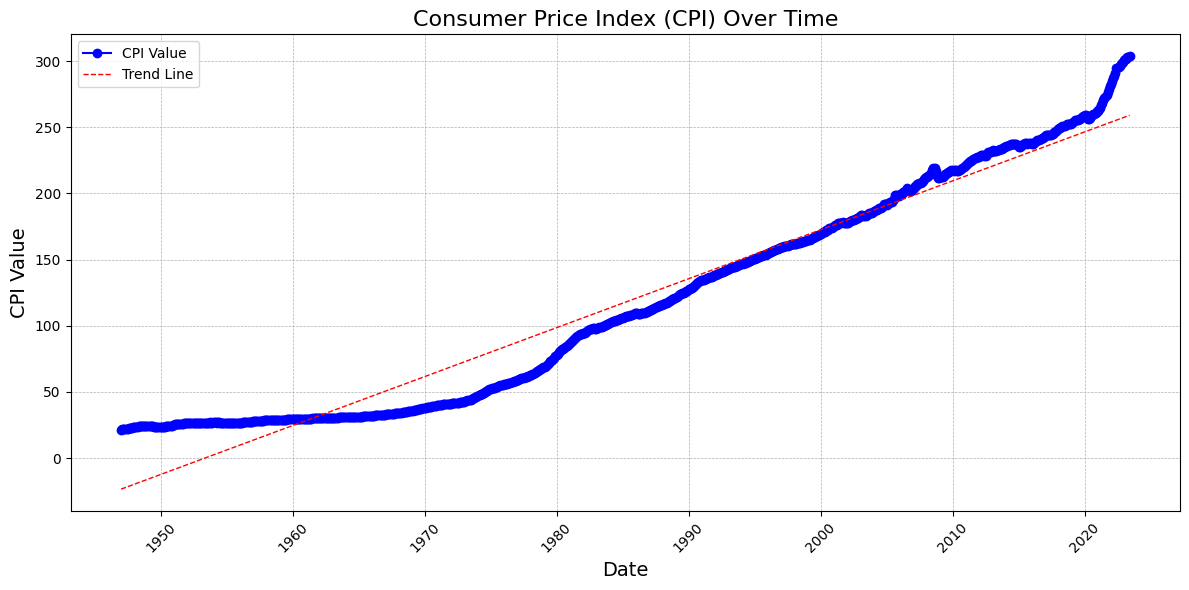

In [88]:
# Plot CPI values over time
plt.figure(figsize=(12, 6))
plt.plot(df_inflation.index, df_inflation['value'], marker='o', linestyle='-', color='b', linewidth=1.5)

plt.title("Consumer Price Index (CPI) Over Time", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("CPI Value", fontsize=14)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)

# Adding a trend line
ordinals = df_inflation.index.map(pd.Timestamp.toordinal)
z = np.polyfit(ordinals, df_inflation['value'], 1)
p = np.poly1d(z)
plt.plot(df_inflation.index, p(ordinals), "r--", linewidth=1, label='Trend Line')

plt.legend(["CPI Value", "Trend Line"], loc="upper left")
plt.tight_layout()
plt.show()

### Adjusting Movie Box Office Revenues for Inflation

We want to make movie box office revenues comparable across different release years by adjusting them for inflation. We use the Consumer Price Index (CPI) data to account for inflation and bring all revenues to a common base year. This way, we can fairly compare the earnings of movies released in different years.

### Steps

- We start with CPI data indexed by date, which represents the inflation rate over time.
- We choose a **base year** (2023) to normalize all other CPI values.

- For each year in our CPI dataset, we calculate an **adjustment factor** by dividing the CPI value of the base year by the CPI of that specific year:


$$
\text{Adjustment Factor} = \frac{\text{CPI of Base Year}}{\text{CPI of Movie Year}}
$$


- Using the adjustment factors calculated above, we adjust each movie’s box office revenue based on its release year.

In [89]:
df_inflation.sample(2)

,value
date,
1970-03-01,38.3
1977-10-01,61.6


In [90]:
df_inflation = df_inflation.reset_index()
df_inflation['year'] = df_inflation['date'].dt.year
df_inflation = df_inflation.groupby('year')['value'].mean()

# Choose base year (the most recent CPI value for 2023)
base_year = 2023
cpi_base = df_inflation[base_year]

# Calculate adjustment factors for each year
df_inflation = cpi_base / df_inflation

In [91]:
movies = pd.read_csv("data/imdb_additional_movies_correct_left_to_scrape.csv")
movies.shape

(1163, 7)

In [92]:
movies.sample(2)

,wikipedia_movie_id,movie_box_office_revenue,budget,opening_weekend,rating_score,producer,release_year
118,187107,NaN,NaN,NaN,7.0,Stuart Heisler,1952
824,2441439,1547397.0,NaN,558908.0,5.0,Zalman King,1988


We want to check for missing CPI values for each year in the movie dataset.

In [93]:
# Extract unique years from the movies dataset
movie_years = movies['release_year'].dropna().unique()

# Extract available years from the CPI data
cpi_years = df_inflation.index.unique()

# Find years in movies that are missing in CPI data
missing_years = set(movie_years) - set(cpi_years)

# Display missing years
print("Years in movies data but missing in CPI data:", sorted(missing_years))

Years in movies data but missing in CPI data: [1921, 1925, 1927, 1929, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1946]


For the missing year, we will use the closest available year’s CPI value

In [94]:
# Fill missing years by reindexing with a full range
all_years = pd.RangeIndex(start=min(df_inflation.index.min(), min(movie_years)),
                          stop=max(df_inflation.index.max(), max(movie_years)) + 1)
# Use closest available year’s CPI value
df_inflation = df_inflation.reindex(all_years).ffill().bfill()

In [95]:
movies = movies.dropna(subset=['movie_box_office_revenue', 'release_year'])

movies.loc[:, 'adjusted_revenue'] = movies.apply(
    lambda x: x['movie_box_office_revenue'] * df_inflation.get(x['release_year'], 1), axis=1
)

<ipython-input-95-4b946b9eb96b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies.loc[:, 'adjusted_revenue'] = movies.apply(


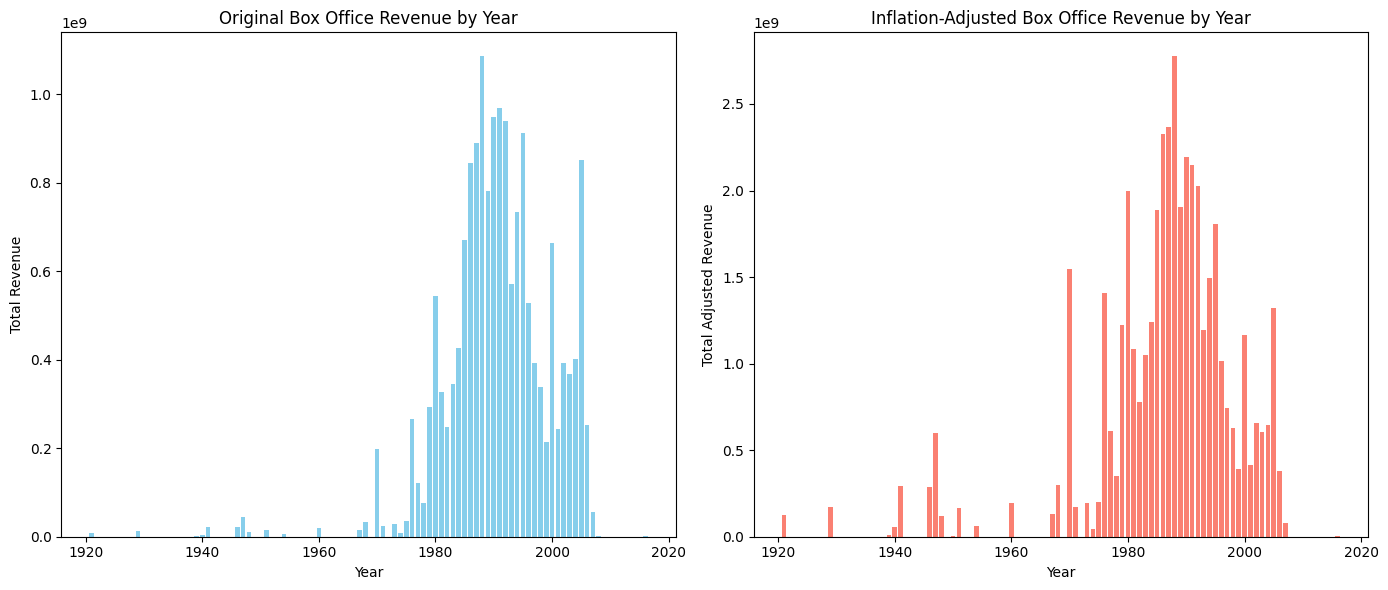

In [97]:
# Group by release year and calculate total revenue for each year
movies_by_year = movies.groupby('release_year').agg({
    'movie_box_office_revenue': 'sum',
    'adjusted_revenue': 'sum'
}).reset_index()

# Plot original vs. inflation-adjusted revenues by year
plt.figure(figsize=(14, 6))

# Plot original revenue by year
plt.subplot(1, 2, 1)
plt.bar(movies_by_year['release_year'], movies_by_year['movie_box_office_revenue'], color='skyblue')
plt.title("Original Box Office Revenue by Year")
plt.xlabel("Year")
plt.ylabel("Total Revenue")

# Plot inflation-adjusted revenue by year
plt.subplot(1, 2, 2)
plt.bar(movies_by_year['release_year'], movies_by_year['adjusted_revenue'], color='salmon')
plt.title("Inflation-Adjusted Box Office Revenue by Year")
plt.xlabel("Year")
plt.ylabel("Total Adjusted Revenue")

plt.tight_layout()
plt.show()
